# About this notebook
### The machine learning model trained in this notebook forecasts the daily # of occupied hospital beds in the Dallas-Forth Worth region based on past data.

The data was obtained from [Combined Hospital Data over Time by Trauma Service Area (TSA)](https://dshs.texas.gov/coronavirus/additionaldata.aspx). **When given a list of future dates as input, the model forecasts the expected # of hospital beds that will be occupied on those days and also provides a plausible range of occupied beds.**

### There are 3 parts to this notebook
1. **[Part 1:](http://localhost:8888/notebooks/Documents/Competitions/Dallas%20Data%20Challenge/Occupied%20Bed%20Forecasting.ipynb#Part-1)** Visualizing # of occupied hospital beds vs available hospital beds in DFW
2. **[Part 2:](http://localhost:8888/notebooks/Documents/Competitions/Dallas%20Data%20Challenge/Occupied%20Bed%20Forecasting.ipynb#Part-2---Creating-a-Model)** Training the model on dates before September, then evaluating its accuracy at forecasting the # of occupied beds available on September dates *(for which data is available)*.
3. [**Part 3:**](http://localhost:8888/notebooks/Documents/Competitions/Dallas%20Data%20Challenge/Occupied%20Bed%20Forecasting.ipynb#Part-3---The-Future) Training the model on all available data *(including September)* and **forecasting the # of beds occupied for future dates: the next 30 days.**

## Note:
The process of training the model for occupied bed prediction is very similar to available bed prediction from the **DFW Available Hospital Bed Forecasting** notebook and that's why there are fewer comments in this notebook. For detailed comments and explanations of the process, please refer to the **DFW Available Hospital Bed Forecasting** Jupyter Notebook.

# Part 1
## Visualizing occupied vs available hospital beds

In [10]:
import pandas as pd
from datetime import datetime
from pandas import DataFrame
from pandas import to_datetime
from pandas import read_csv
from pandas import to_datetime
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
# fbprophet is Facebook's open source library for time series prediction
from fbprophet import Prophet

In [11]:
# read in the data from the occupied_beds.csv and available_beds.csv files
occupied = pd.read_csv(os.path.join("occupied_beds.csv"), engine='python')
occupied = occupied.transpose() # switch rows and columns
available = pd.read_csv(os.path.join("available_beds.csv"), engine='python')
available = available.transpose() # switch rows and columns

# Given a string, this function returns a number. The reason for this is because when splitting the data
#.   by spaces, it contains commas and new-line characters.
def getNumberFromString(number):
    s = ""
    for pos in range(0, len(bed_number)):
        if(not bed_number[pos].isdigit()):
            break
        s += bed_number[pos]
    return s

In [12]:
# x1: List of # of occupied hospital beds
# x2: List of # of available hospital beds
x1 = []
x2 = []
# The "Dallas/Ft.Worth" can be switched out with any city in the dataset

for bed_number in str(occupied["Dallas/Ft. Worth"]).split(" "):
    if(not bed_number[:1].isdigit()):
        continue
    x1.append(int(getNumberFromString(bed_number)))
    
for bed_number in str(available["Dallas/Ft. Worth"]).split(" "):
    if(not bed_number[:1].isdigit()):
        continue
    x2.append(int(getNumberFromString(bed_number)))

No handles with labels found to put in legend.


<Figure size 21600x10800 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

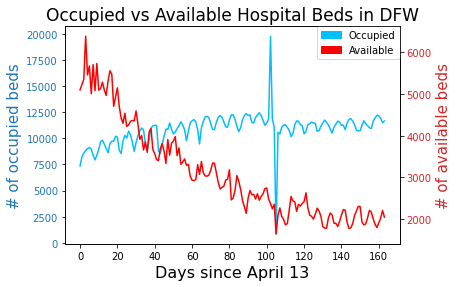

Max # of occupied beds: 19753


In [58]:
figure(num=None, figsize=(18, 9), dpi=1200, facecolor='w', edgecolor='k')
plt.figure(figsize = (18,9))
import matplotlib.patches as mpatches
fig, ax1 = plt.subplots()
ax1.set_title("Occupied vs Available Hospital Beds in DFW", fontsize = 17)

color = 'tab:blue'
ax1.set_xlabel('Days since April 13', fontsize=16)
ax1.set_ylabel('# of occupied beds', color=color,fontsize=15)
ax1.plot(x1, color = 'deepskyblue')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper right")

blue_patch = mpatches.Patch(color='deepskyblue', label='Occupied')
red_patch = mpatches.Patch(color='red', label='Available')
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0, handles=[blue_patch, red_patch])

ax2 = ax1.twinx()  
color = 'red'
ax2.set_ylabel('# of available beds', color='tab:red',fontsize=15)
ax2.plot(x2, color = color)
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.show()
# fig.savefig('Occupied vs Available Hospital Beds in DFW.png', dpi=1200)
print("Max # of occupied beds:", max(x1))

# Part 2 - Creating a Model

In [59]:
x = x1

end_date = pd.to_datetime("2020-04-12") + pd.DateOffset(days=len(x) - 1)
dates = pd.date_range(start="2020-04-12",end=end_date)
dates = [str(i)[:10] for i in dates]

# This code slices the last 22 days off the training data and saves it for later for the model to forecast
# At the time of coding this, the testing data spans from September 1st to 22nd
testD = dates[-22:]
testX = x[-22:]
dates = dates[:-22]
x = x[:-22]
print("# of Dates:", len(dates), "\nFrom", dates[0], "to", dates[len(dates) - 1])
print("# of Dates to Forecast:", len(testD), "\nFrom", testD[0], "to", testD[len(testD) - 1])

# of Dates: 142 
From 2020-04-12 to 2020-08-31
# of Dates to Forecast: 22 
From 2020-09-01 to 2020-09-22


In [60]:
# Create a pandas DataFrame object from the list of dates and hospital beds
df = pd.DataFrame({'Dates' : dates, 'Beds' : x})
df

,Dates,Beds
0,2020-04-12,7347
1,2020-04-13,8219
2,2020-04-14,8589
3,2020-04-15,8811
4,2020-04-16,9014
...,...,...
137,2020-08-27,11343
138,2020-08-28,11636
139,2020-08-29,11545
140,2020-08-30,11225


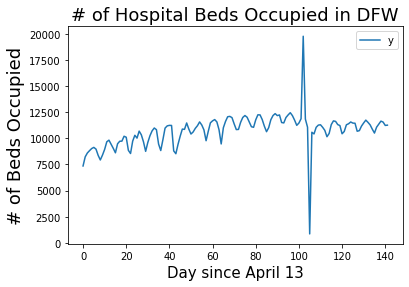

In [71]:
df.plot()
plt.title("# of Hospital Beds Occupied in DFW", fontsize=18)
plt.xlabel('Day since April 13',fontsize=15)
plt.ylabel('# of Beds Occupied',fontsize=18)
# plt.savefig('Hospital Beds Occupied.png', dpi=1200)
plt.show()

## Training the Model
##### For a detailed explanation of what's happening, please refer to the **DFW Available Hospital Bed Forecasting** notebook. 

What I am doing below is training the model on the data (dates and the # of occupied hospital beds on each date)

In [64]:
# prophet requires the column names to be "ds" and "y"
df.columns = ['ds', 'y']
# make the model
model = Prophet()
# train the model on the dataset (in this case dataframe df)
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [65]:
# Generate a list of future dates for the model to predict
future = DataFrame(testD)
future.columns = ['ds']

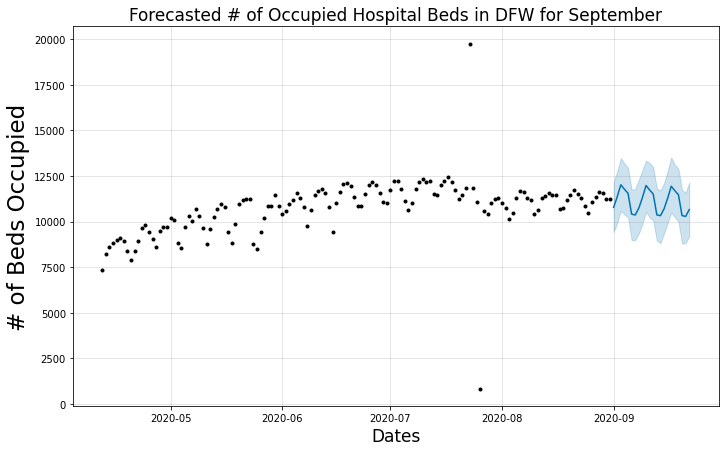

In [73]:
# forecast contains the predictions for the dates we provided
forecast = model.predict(future)

# plot forecast
model.plot(forecast)
plt.title("Forecasted # of Occupied Hospital Beds in DFW for September", fontsize=17)
plt.xlabel('Dates',fontsize=17)
plt.ylabel('# of Beds Occupied',fontsize=23)
# plt.savefig('September Occupied Forecast.png', dpi=1200)
plt.show()

## Evaluating the Model
After having trained the model and having it predict the daily # of occupied beds from September 1st to 22nd, in this step I will evaluate the model's performance.

Among the useful information the model provides is the **expected # of occupied beds** and **an expected range of occupied beds** *(interval)*.

Below are some of the metrics I am examining

- Percent Error
- Mean Absolute Error (MAE)
- Percentage of Dates within predicted *interval*

### 1. Visualizing Forecasts vs Actual # of Occupied Beds

In [74]:
intervals = [] # Intervals of bed predictions
predicted = [] # Predicted # of occupied beds
differences = [] # Difference (actual - predicted)

# For each date that the model had to forecast, I get the predicted number of beds, and the confidence interval (or range of beds for that day)
for count, (pred, lower, upper) in enumerate(zip(forecast['yhat'], forecast['yhat_lower'], forecast['yhat_upper'])):
    intervals.append("{:.0f} - {:.0f}".format(lower, upper))
    differences.append(testX[count] - int(round(pred)))
    predicted.append(int(round(pred)))

# data frame of the summary between actual # and forecasted # of occupied beds
summary = pd.DataFrame({'Dates' : testD, 'Actual': testX, 'Predicted' : predicted, 
                       'Difference' : differences, 'Intervals' : intervals})
# Displaying the dataframe
print("       # of Beds Forecasted vs Actual")
summary

       # of Beds Forecasted vs Actual


,Dates,Actual,Predicted,Difference,Intervals
0,2020-09-01,10809,10779,30,9426 - 12196
1,2020-09-02,11431,11358,73,9925 - 12756
2,2020-09-03,11790,12017,-227,10596 - 13481
3,2020-09-04,11869,11774,95,10395 - 13189
4,2020-09-05,11645,11552,93,10231 - 12935
5,2020-09-06,11308,10411,897,8984 - 11742
6,2020-09-07,10760,10363,397,8977 - 11787
7,2020-09-08,10705,10738,-33,9343 - 12291
8,2020-09-09,10723,11318,-595,9878 - 12823
9,2020-09-10,11249,11976,-727,10546 - 13340


In [85]:
error = []
absolute_error = 0 # Mean Absolute Error
contains = [] # True or False based on whether a forecasted interval contains the actual # of occupied beds
average = 0
for i in range (0, len(predicted)):
    # Calculate percent error for each date.  testX is a list of the actual # of beds
    average += (testX[i] - predicted[i])/testX[i] * 100
    error.append(round(((testX[i] - predicted[i])/testX[i] * 100), 1))
    absolute_error += abs(testX[i] - predicted[i])
    
    # Determining whether forecast interval contains actual # of beds
    lower_bound = forecast['yhat_lower'][i]
    upper_bound = forecast['yhat_upper'][i]
    contains.append((lower_bound <= testX[i] and testX[i] <= upper_bound))

# calculate average percent error
average = round(average/len(error),1)
# calculate mean absolute error
absolute_error = round(absolute_error / len(error))

# Count # of forecasted intervals that contained the actual # of occupied beds
numberCorrect = sum(interval for interval in contains)
percentCorrect = int((numberCorrect * 100)/len(contains))
print("---------------------------------")
print("AVERAGE PERCENT ERROR:", average, "%")
print("MEAN ABSOLUTE ERROR:", absolute_error, "beds\n")
print("On {0}% of the days ({1} out of 22 days), the model's forecast interval of the # of occupied beds contained the actual # of beds available on that day.".format(percentCorrect, numberCorrect))
print("---------------------------------")

results = pd.DataFrame({'Dates' : testD, 'Percent Error': [str(e) + "%" for e in error],
                        'Accurate Forecast Interval' : contains})
results

---------------------------------
AVERAGE PERCENT ERROR: 2.7 %
MEAN ABSOLUTE ERROR: 474 beds

On 95% of the days (21 out of 22 days), the model's forecast interval of the # of occupied beds contained the actual # of beds available on that day.
---------------------------------


,Dates,Percent Error,Accurate Forecast Interval
0,2020-09-01,0.3%,True
1,2020-09-02,0.6%,True
2,2020-09-03,-1.9%,True
3,2020-09-04,0.8%,True
4,2020-09-05,0.8%,True
5,2020-09-06,7.9%,True
6,2020-09-07,3.7%,True
7,2020-09-08,-0.3%,True
8,2020-09-09,-5.5%,True
9,2020-09-10,-6.5%,True


## Results/Conclusion
- The model had an **average percent of error of about 2.7%.** Taking into consideration the 2 outliers on July 23rd, and 26th, this is a good result.
- Additionally, when predicting the # of beds occupied for the first 22 days in September, the model provided an expected range of occupied beds. For **21 out of the 22 days (95%)**, this expected range accurately captured the correct # of occupied beds, meaning that the model can forecast the ballpark of number of beds occupied.
- **The model's performance will improve as more time passes by and more data is available.**

# Part 3 - The Future
### Forecasting future dates - the next 31 days
In this part, I will train a model to forecast the daily # of occupied hospital beds in Dallas/Fort Worth for dates that have not yet arrived *(late September and October)*. 

This time, I will include data from September when training the model.

In [109]:
x = []

# Reading & storing the # of available beds in DFW
for bed_number in str(occupied["Dallas/Ft. Worth"]).split(" "):
    if(not bed_number[:1].isdigit()):
        continue
    
    x.append(int(getNumberFromString(bed_number)))
        
# Generate dates from April 12th to last date in the dataset
end_date = pd.to_datetime("2020-04-12") + pd.DateOffset(days=len(x) - 1)
dates = pd.date_range(start="2020-04-12",end=end_date)
dates = [str(i)[:10] for i in dates]

print("# of Dates:", len(dates), "\nFrom", dates[0], "to", dates[len(dates) - 1])

# of Dates: 164 
From 2020-04-12 to 2020-09-22


In [110]:
df = pd.DataFrame({'Dates' : dates, 'Beds' : x})
df.columns = ['ds', 'y']
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [111]:
# Generating a list of future dates for the model to forecast
future_dates = pd.date_range(start="2020-09-23",end="2020-10-23")
future = DataFrame(future_dates)
future.columns = ['ds']

In [112]:
# forecast contains the predictions for the dates we provided
forecast = model.predict(future)

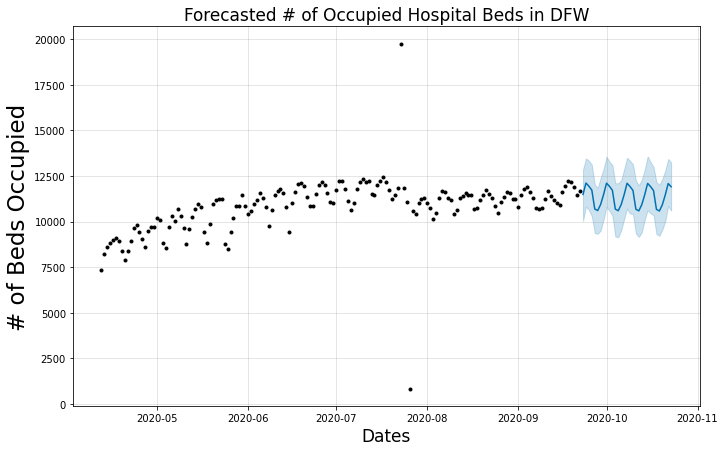

In [113]:
alternate = forecast[:]

model.plot(alternate)
plt.title("Forecasted # of Occupied Hospital Beds in DFW", fontsize=17)
plt.xlabel('Dates',fontsize=17)
plt.ylabel('# of Beds Occupied',fontsize=23)
# plt.savefig('Future Occupied Forecast.png', dpi=1200)
plt.show()

### Zoomed-in graph
The code below creates a graph that zooms in on the graph above. **It shows the last 31 days where the # of occupied beds was known next to the forecasted # of beds in Dallas from September 23rd to October 23rd that the model has predicted.**

In [114]:
toplot = []
before = 31
for i in x[-before:]:
    toplot.append(i)
for i in alternate['yhat']:
    toplot.append(int(i))

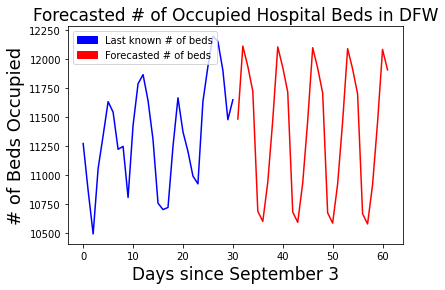

In [115]:
# total occupied beds
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
alternate

plt.title("Forecasted # of Occupied Hospital Beds in DFW", fontsize=17)
plt.xlabel('Days since September 3',fontsize=17)
plt.ylabel('# of Beds Occupied',fontsize=18)

# Generate the before and after lists for x values
x1 = [i for i in range(0,before)]
x2 = [i for i in range(before, len(alternate) + before)]

# Create the legend
blue_patch = mpatches.Patch(color='blue', label='Last known # of beds')
red_patch = mpatches.Patch(color='red', label='Forecasted # of beds')
plt.legend(handles=[blue_patch, red_patch])

plt.plot(x1, toplot[:before], color='blue')
plt.plot(x2, toplot[before:], color='red')

# plt.savefig('Future Occupied Forecast Zoomed.png', dpi=1200)

plt.show()

# End of Notebook   